# This notebook contains the code necessary to visualise the input channels, original annotations and processed segmentation masks for slices of samples in the BraTS dataset.
# **Instructions**: Run all cells

In [3]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.Meter import Meter, DiceLoss, BCEDiceLoss, dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss

import warnings
warnings.simplefilter("ignore")


/home/incomple_/Term6/3D_Brain_Tumor_Seg_V2/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
# Global config class
class GlobalConfig:
    train_root_dir = './BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    # for reproducibility
    seed = 42


def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def load_img(file_path):
    data = nib.load(file_path)
    data = np.asarray(data.dataobj)
    return data

config = GlobalConfig()
seed_everything(config.seed)


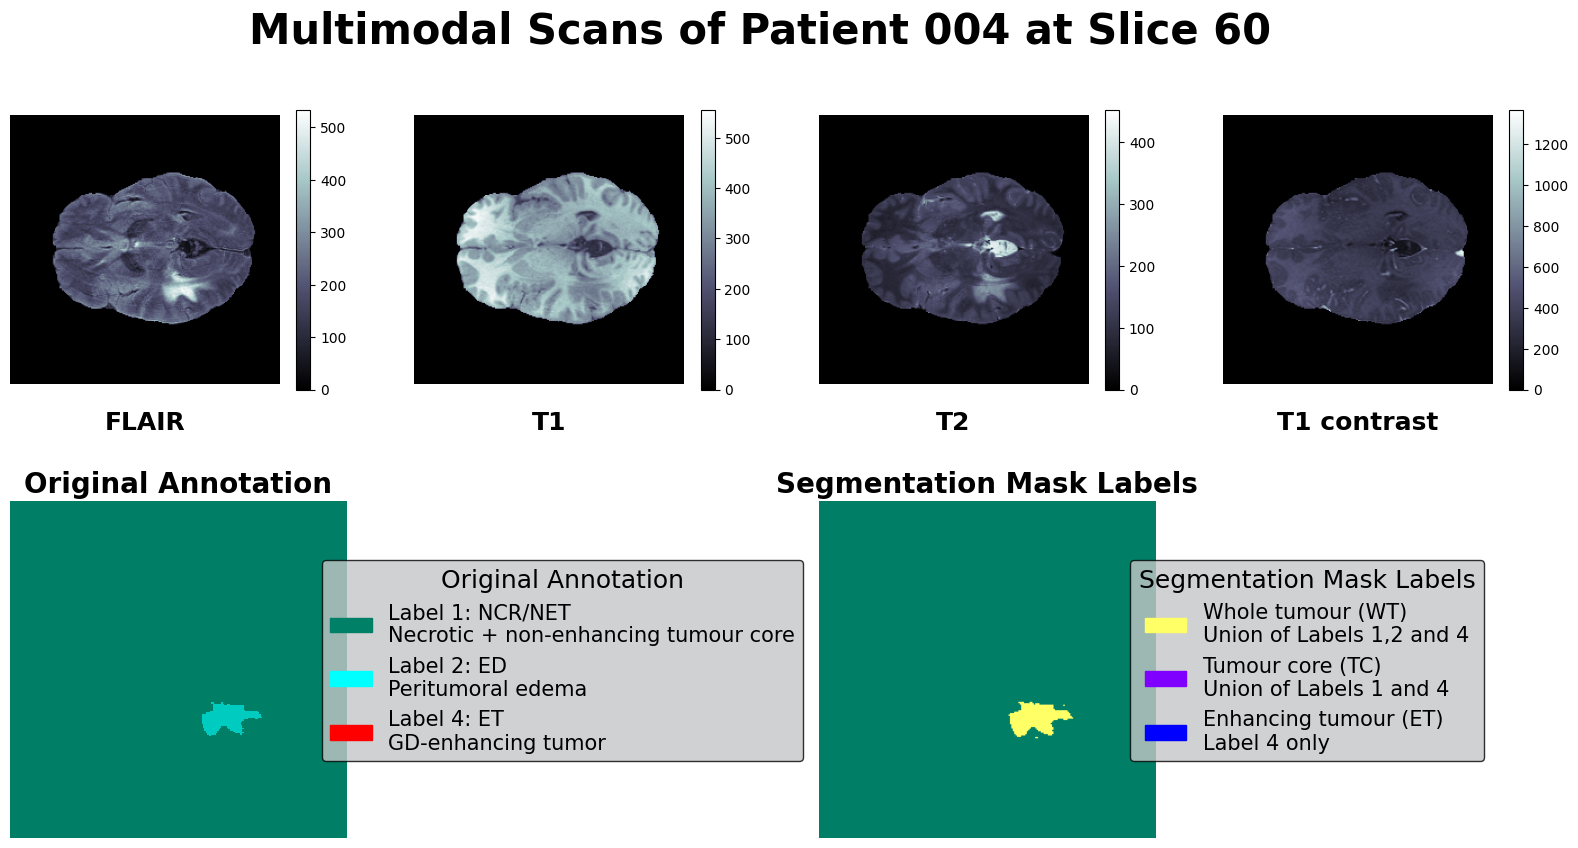

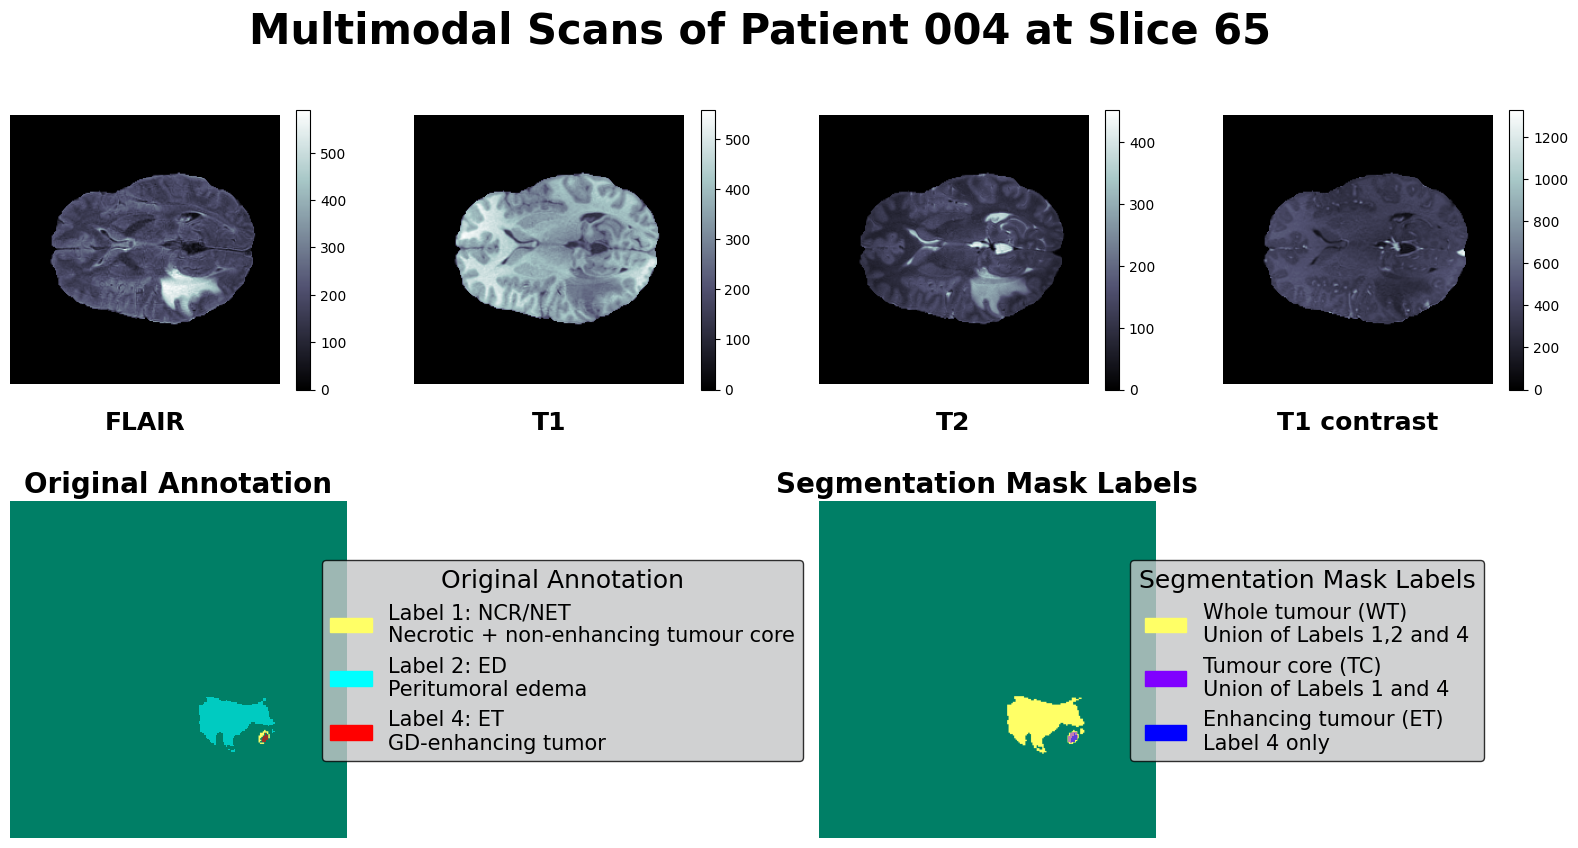

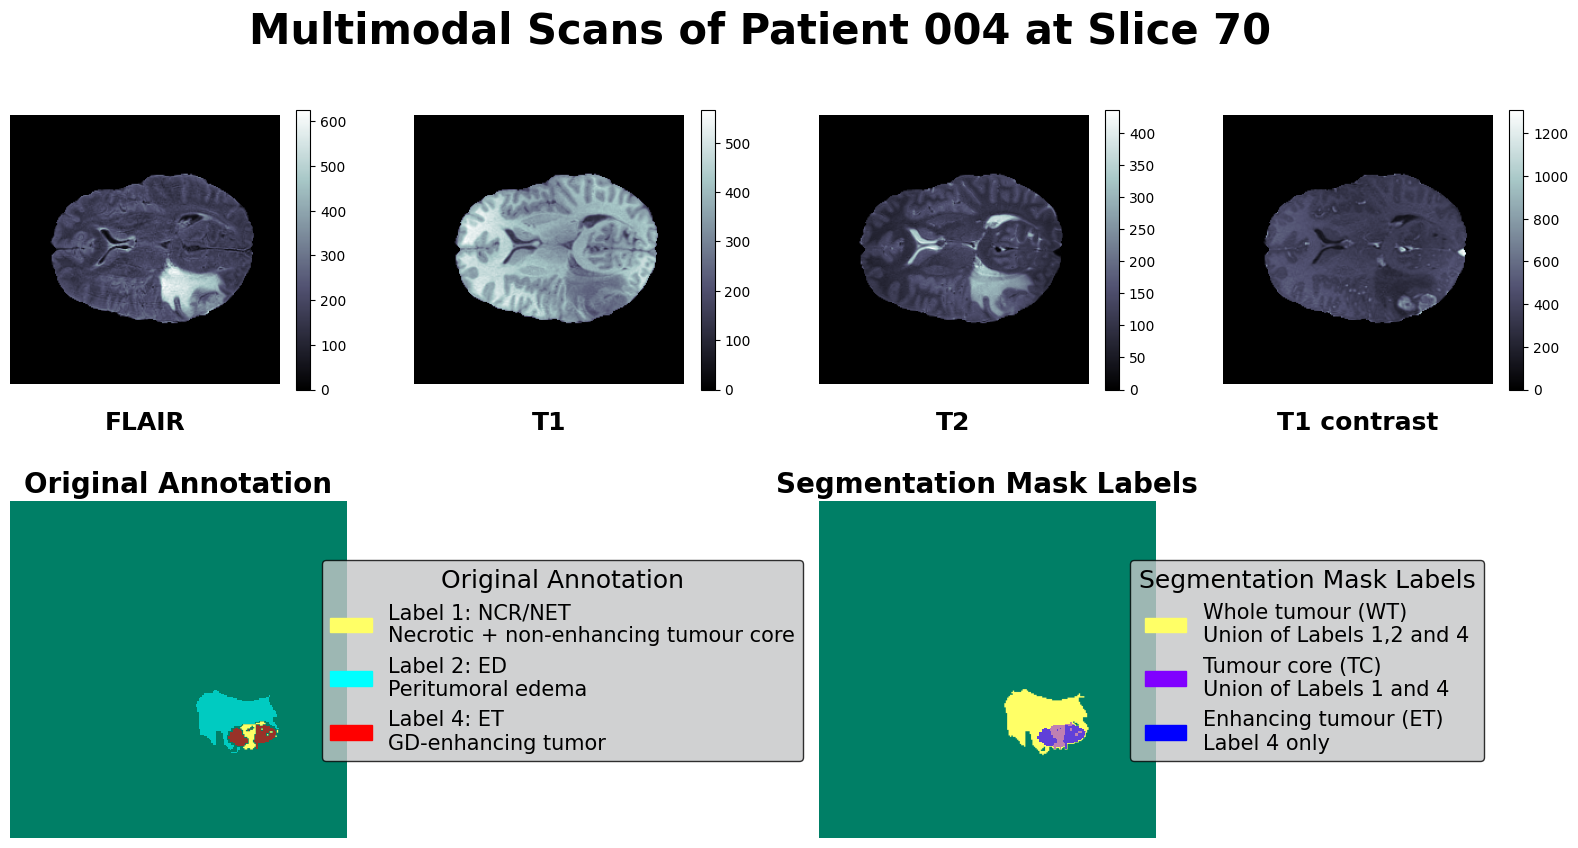

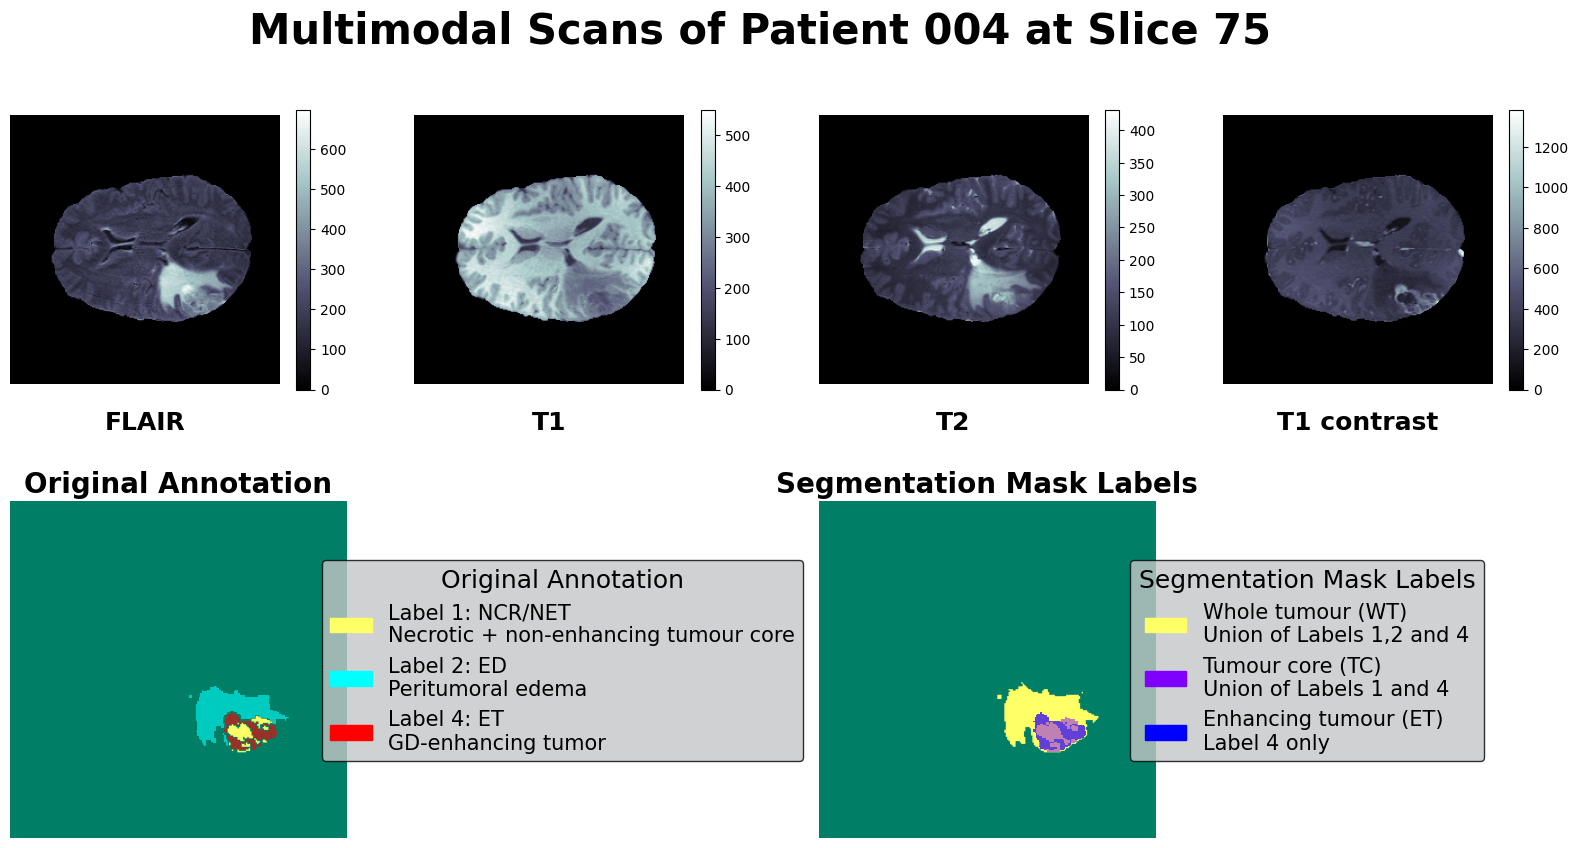

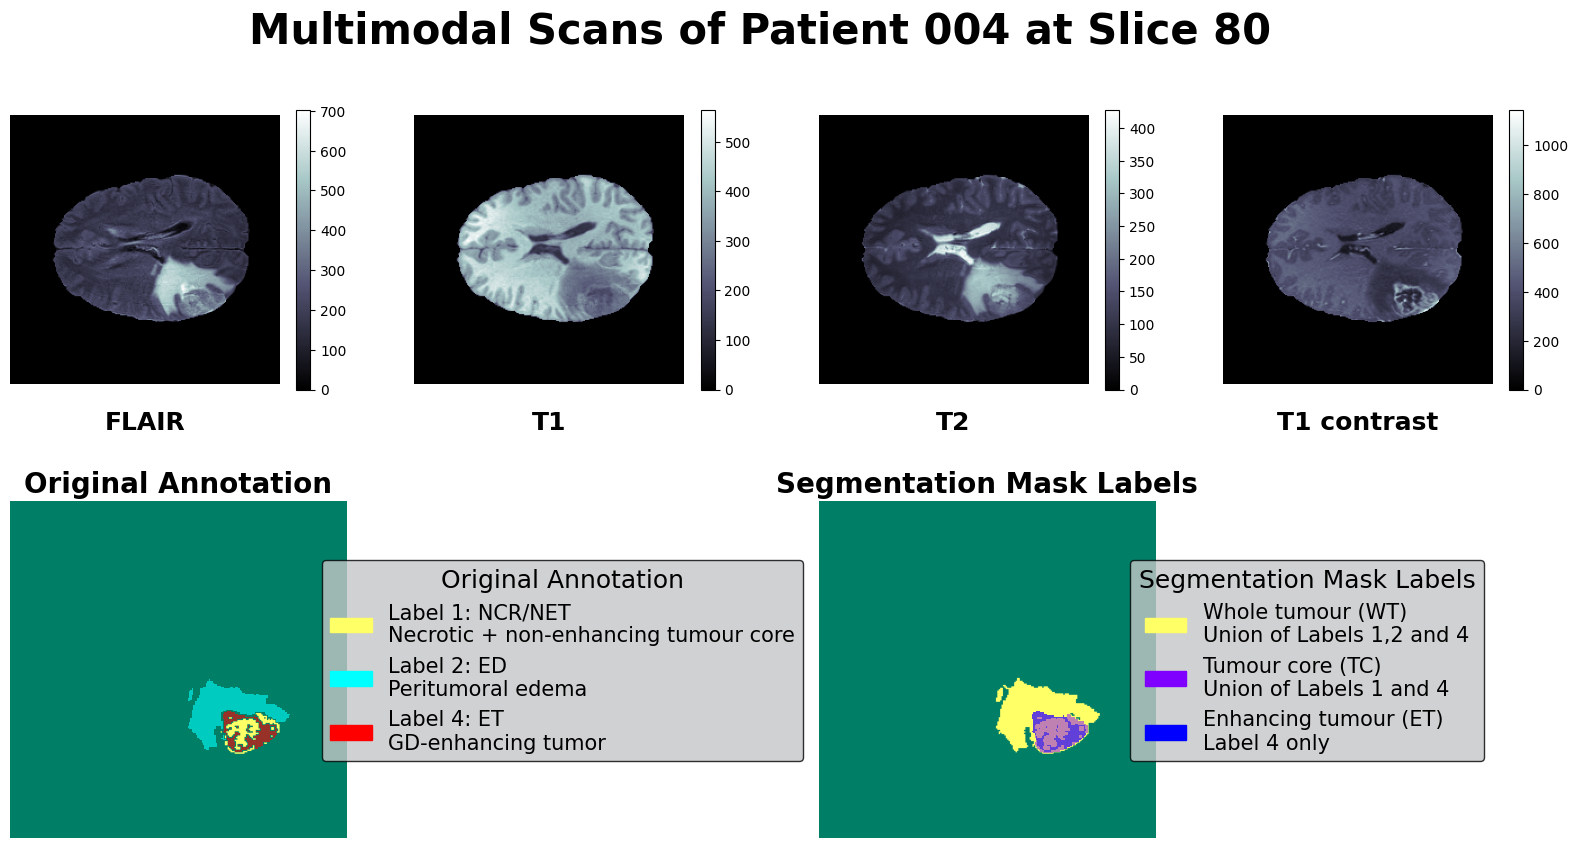

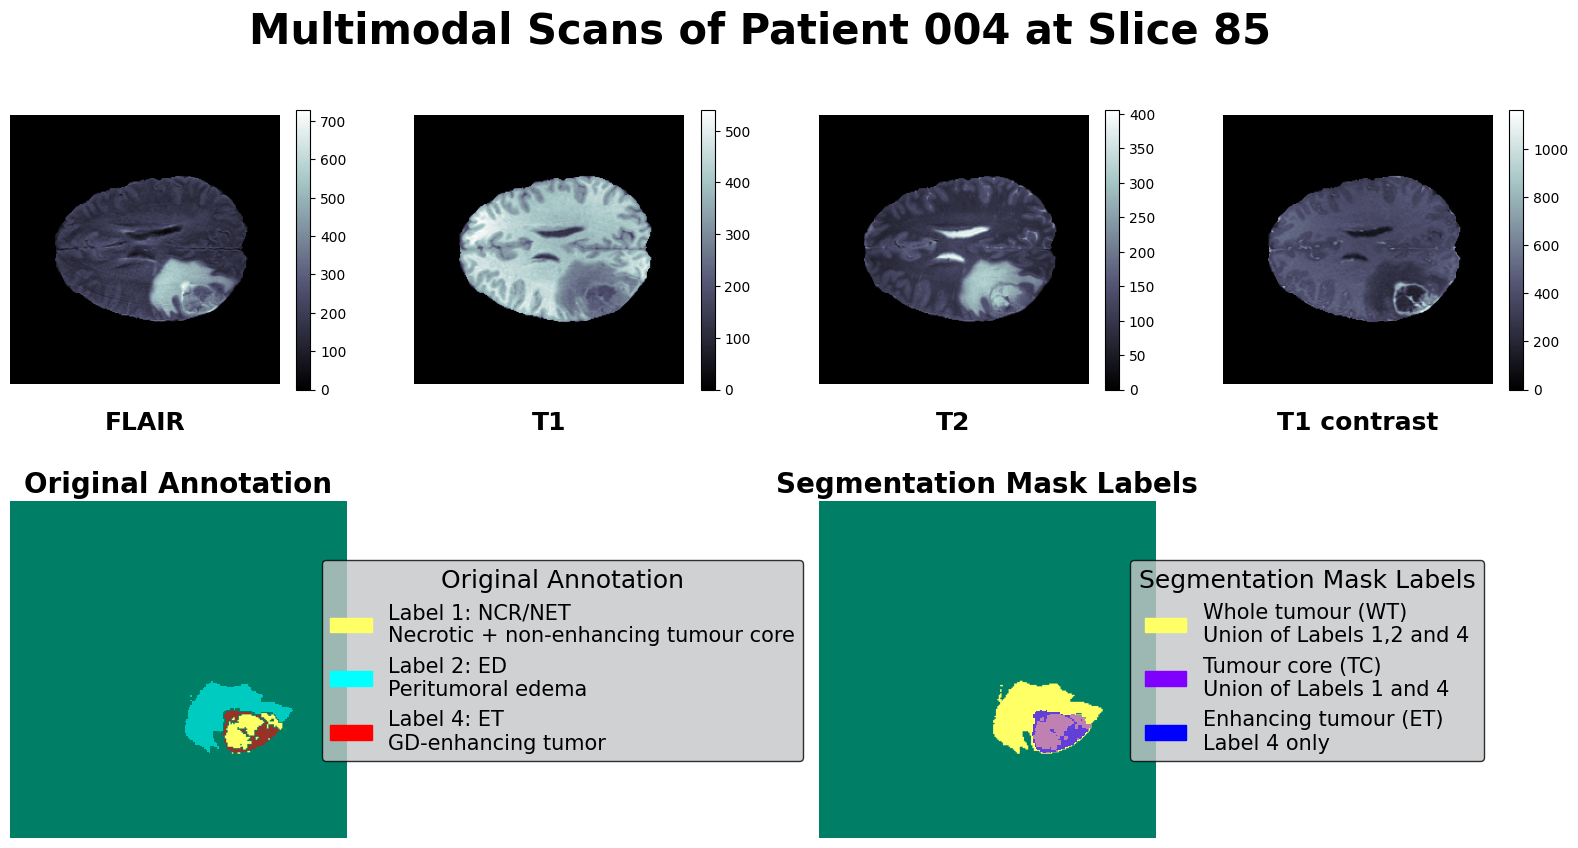

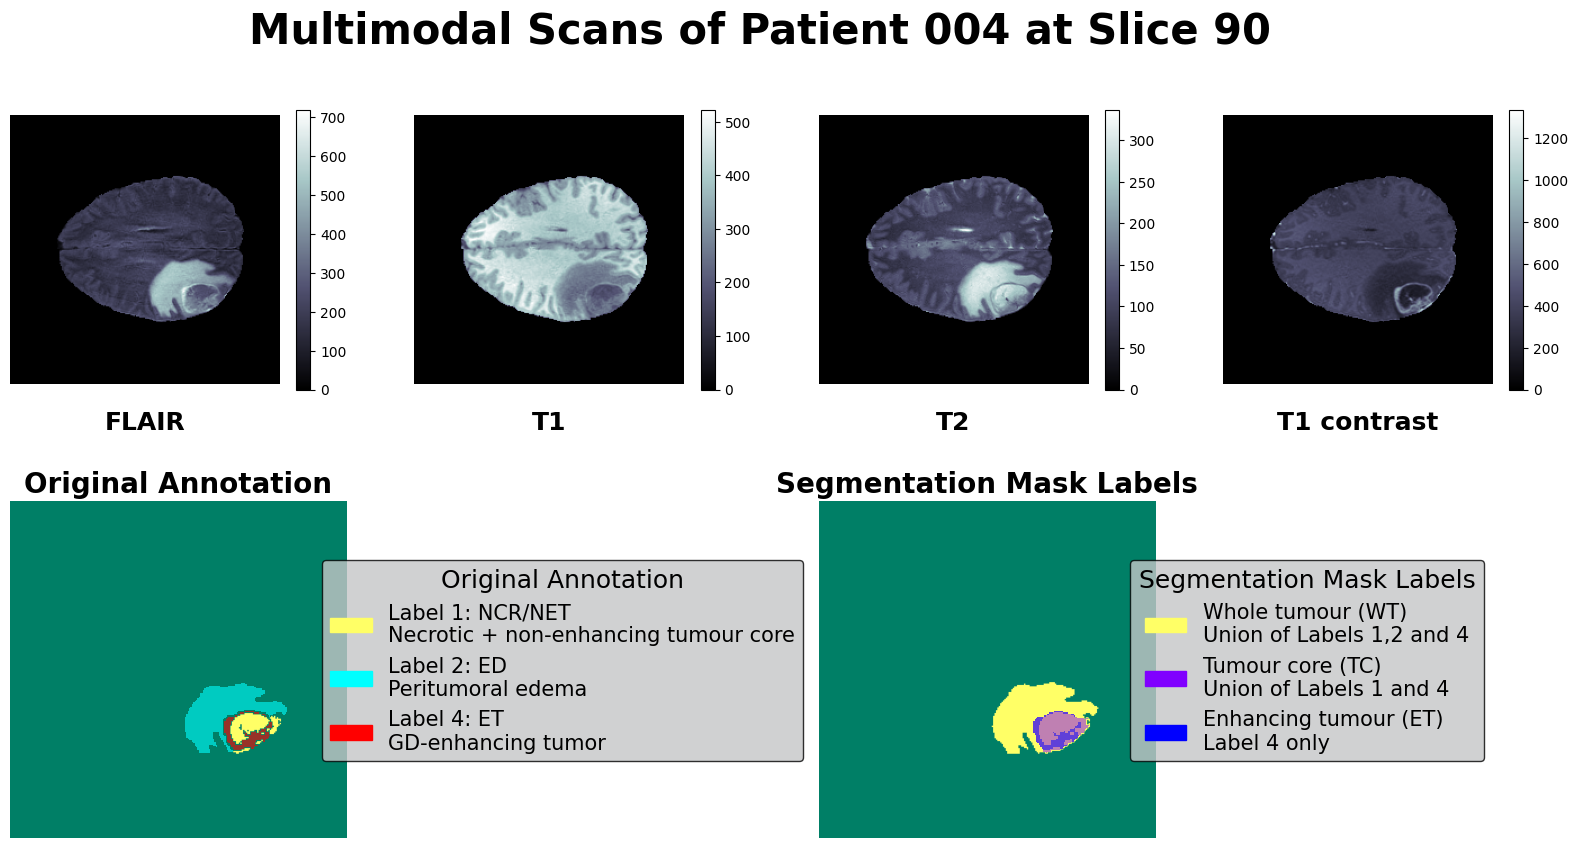

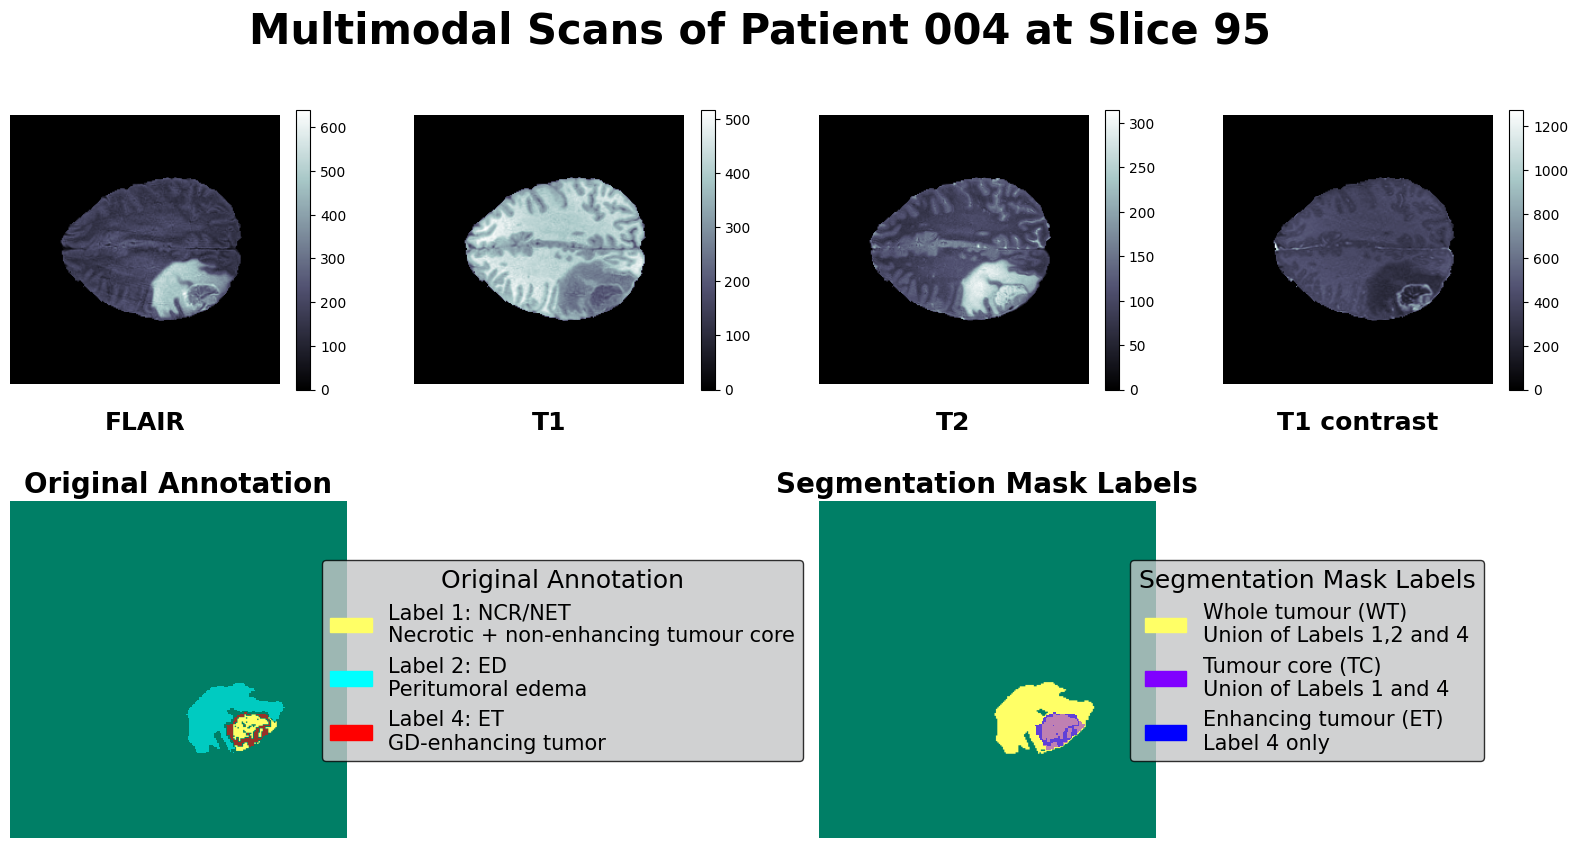

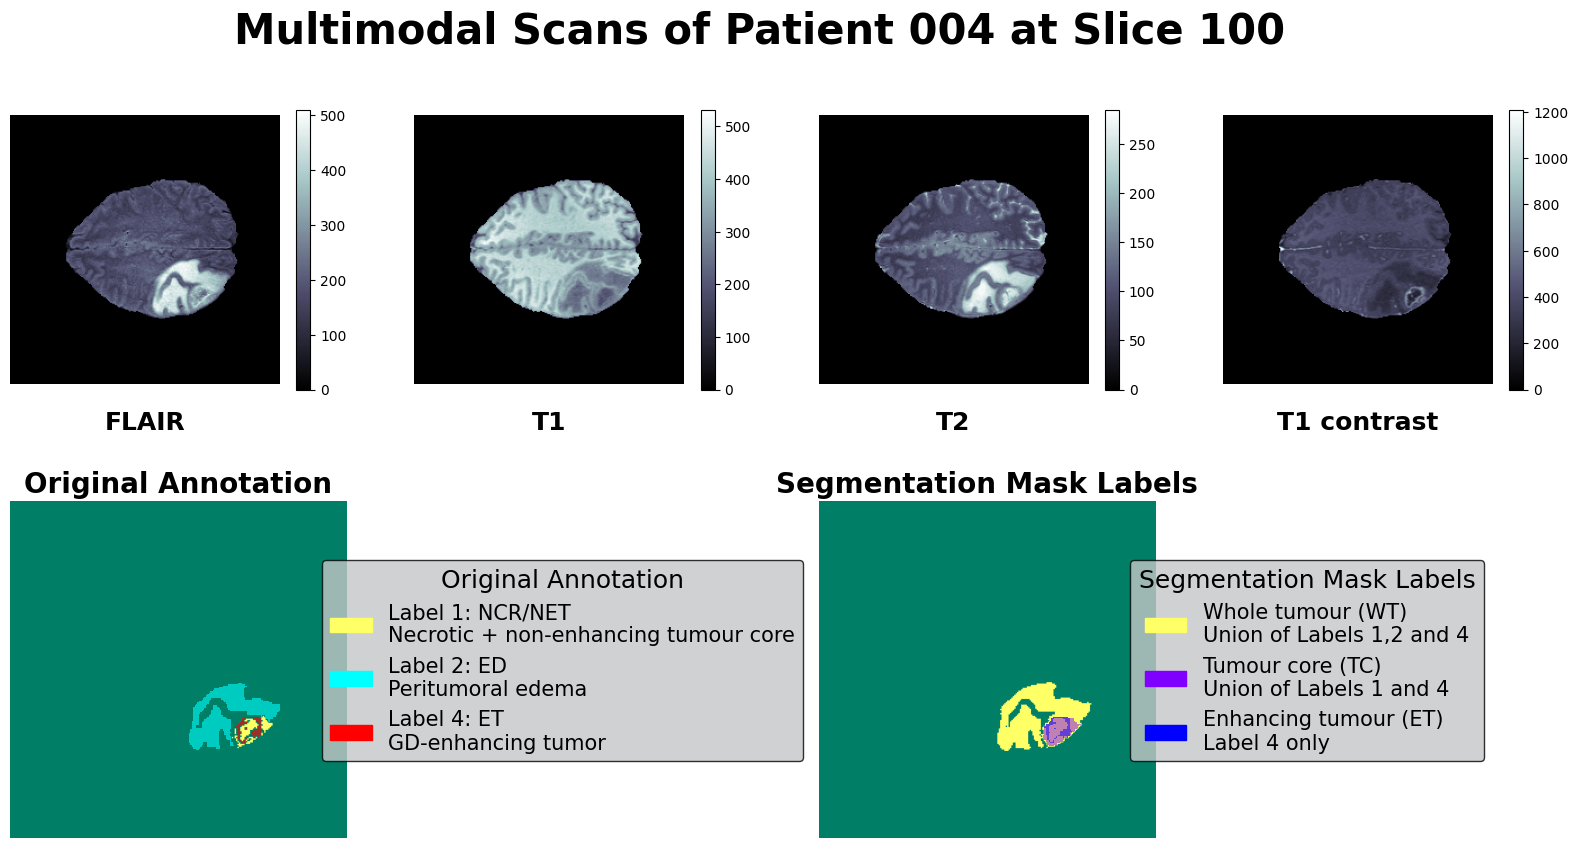

In [70]:
# Change these to visualise brain MRIs of different patients, and at different slices
######################################
PATIENT_IDX = 4  # 1 - 369
######################################

for SLICE_IDX in range(60, 100+1, 5):


    sample_filename = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_flair.nii"
    sample_filename_mask = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_seg.nii"

    sample_img = load_img(sample_filename)
    sample_mask = load_img(sample_filename_mask)

    sample_filename2 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1.nii"
    sample_img2 = load_img(sample_filename2)

    sample_filename3 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t2.nii"
    sample_img3 = load_img(sample_filename3)

    sample_filename4 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1ce.nii"
    sample_img4 = load_img(sample_filename4)

    # In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
    # namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
    # The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.
    # We hence create 3 sets of mask. This will eventually be stacked upon each other during preprocessing in the Dataset Class.
    mask_WT = sample_mask.copy()
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = sample_mask.copy()
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = sample_mask.copy()
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1

    mask_NCR_NET = sample_mask.copy()
    mask_NCR_NET[mask_NCR_NET == 1] = 1
    mask_NCR_NET[mask_NCR_NET == 2] = 0
    mask_NCR_NET[mask_NCR_NET == 4] = 0

    mask_ED = sample_mask.copy()
    mask_ED[mask_ED == 1] = 0
    mask_ED[mask_ED == 2] = 1
    mask_ED[mask_ED == 4] = 0


    # https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
    # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib


    fig = plt.figure(figsize=(20, 10))

    gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

    #  Varying density along a streamline
    ax0 = fig.add_subplot(gs[0, 0])
    # Show all columns and rows, but a specific slice index
    flair = ax0.imshow(sample_img[:, :, SLICE_IDX], cmap='bone')
    ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(flair)

    #  Varying density along a streamline
    ax1 = fig.add_subplot(gs[0, 1])
    t1 = ax1.imshow(sample_img2[:, :, SLICE_IDX], cmap='bone')
    ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t1)

    #  Varying density along a streamline
    ax2 = fig.add_subplot(gs[0, 2])
    t2 = ax2.imshow(sample_img3[:, :, SLICE_IDX], cmap='bone')
    ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t2)

    #  Varying density along a streamline
    ax3 = fig.add_subplot(gs[0, 3])
    t1ce = ax3.imshow(sample_img4[:, :, SLICE_IDX], cmap='bone')
    ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t1ce)

    ax4 = fig.add_subplot(gs[1, 0:1])

    j1 = ax4.imshow(mask_NCR_NET[:, :, SLICE_IDX], cmap='summer',)
    j2 = ax4.imshow(np.ma.masked_where(
        mask_ED[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='cool', alpha=0.6)
    j3 = ax4.imshow(np.ma.masked_where(
        mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='autumn', alpha=0.6)

    ax4.set_title("Original Annotation", fontsize=20, weight='bold')

    colors_j = [im.cmap(im.norm(1)) for im in [j1, j2, j3]]
    labels_j = ['Label 1: NCR/NET\nNecrotic + non-enhancing tumour core',
                'Label 2: ED\nPeritumoral edema ', 'Label 4: ET\nGD-enhancing tumor ']
    patches_j = [mpatches.Patch(
        color=colors_j[i], label=f"{labels_j[i]}") for i in range(len(labels_j))]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches_j, bbox_to_anchor=(0.9, 0.85), loc=2, borderaxespad=0.4, fontsize=15,
            title='Original Annotation', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

    ax5 = fig.add_subplot(gs[1, 2:3])


    l1 = ax5.imshow(mask_WT[:, :, SLICE_IDX], cmap='summer',)
    l2 = ax5.imshow(np.ma.masked_where(
        mask_TC[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='rainbow', alpha=0.5)
    l3 = ax5.imshow(np.ma.masked_where(
        mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='winter', alpha=0.5)

    ax5.set_title("Segmentation Mask Labels", fontsize=20, weight='bold')

    colors_l = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
    labels_l = ['Whole tumour (WT)\nUnion of Labels 1,2 and 4',
                'Tumour core (TC)\nUnion of Labels 1 and 4', 'Enhancing tumour (ET)\nLabel 4 only']
    patches_l = [mpatches.Patch(
        color=colors_l[i], label=f"{labels_l[i]}") for i in range(len(labels_l))]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches_l, bbox_to_anchor=(0.9, 0.85), loc=2, borderaxespad=0.4, fontsize=15,
            title='Segmentation Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4, ax5]]

    plt.suptitle(f"Multimodal Scans of Patient {PATIENT_IDX:03} at Slice {SLICE_IDX}",
                 fontsize=30, weight='bold')
    plt.show()


